### The German Traffic Sign Benchmark

Student Name 1: Panagiotis Michalopoulos

Student Name 2: Filip Finfando

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2019-04-08 18:22:32--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  FullIJCNN2013.zip
replace FullIJCNN2013/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)
#SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

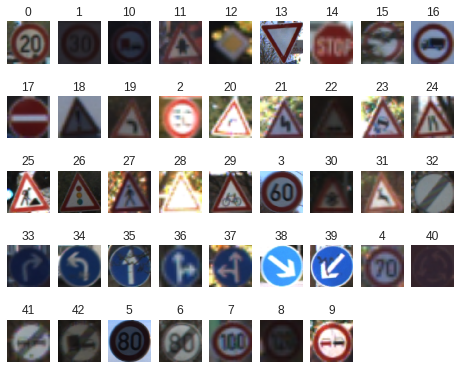

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.3: Transfer learning

In [6]:
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

baseline = DenseNet201(weights='imagenet', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), include_top=False)

x = baseline.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_classes, activation='softmax')(x)
densenet201 = Model(inputs=baseline.input, outputs=predictions)

for i,layer in enumerate(densenet201.layers):
  print(i,layer.name)  

print('\nnon-trainable')
for layer in densenet201.layers[:141]:
    layer.trainable=False
    print(layer.name)

print('\ntrainable')
for layer in densenet201.layers[141:]:
    layer.trainable=True
    print(layer.name)

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
densenet201.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
densenet201.summary()

Instructions for updating:
Colocations handled automatically by placer.
0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_

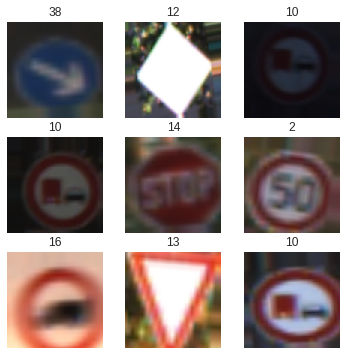

Epoch 1/60
 - 40s - loss: 0.0240 - acc: 0.9941 - val_loss: 0.7118 - val_acc: 0.8333
Epoch 2/60
 - 40s - loss: 0.0416 - acc: 0.9882 - val_loss: 1.1182 - val_acc: 0.7024
Epoch 3/60
 - 40s - loss: 0.0887 - acc: 0.9848 - val_loss: 0.7291 - val_acc: 0.8095
Epoch 4/60
 - 40s - loss: 0.0864 - acc: 0.9814 - val_loss: 0.8304 - val_acc: 0.7540
Epoch 5/60
 - 40s - loss: 0.0361 - acc: 0.9916 - val_loss: 0.9236 - val_acc: 0.7817
Epoch 6/60
 - 40s - loss: 0.0438 - acc: 0.9932 - val_loss: 1.1400 - val_acc: 0.7460
Epoch 7/60
 - 40s - loss: 0.0633 - acc: 0.9865 - val_loss: 1.4300 - val_acc: 0.7103
Epoch 8/60
 - 40s - loss: 0.0340 - acc: 0.9941 - val_loss: 0.5109 - val_acc: 0.8770
Epoch 9/60
 - 40s - loss: 0.0077 - acc: 0.9983 - val_loss: 0.3551 - val_acc: 0.9048
Epoch 10/60
 - 40s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3231 - val_acc: 0.9048
Epoch 11/60
 - 40s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.2992 - val_acc: 0.9206
Epoch 12/60
 - 40s - loss: 7.3815e-04 - acc: 1.0000 - val_loss: 0.2902 - v

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
# datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
# datagen.fit(tr_signs, augment=True)


# print(len(tr_signs))
# tr_signs_aug = np.array(tr_signs, copy=True) 
# tr_labels_aug = np.array(tr_labels, copy=True)

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(tr_signs, augment=True)

# # Concatenating the old data with the augmented data
# tr_signs_aug  = np.concatenate((tr_signs_aug, tr_signs), axis=0)
# tr_labels_aug  = np.concatenate((tr_labels_aug, tr_labels), axis=0)

# print(len(tr_signs_aug))

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break



train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
data = densenet201.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=32), epochs=60, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard, early_stopping])

start = time()
loss, acc = densenet201.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('DenseNet201 took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

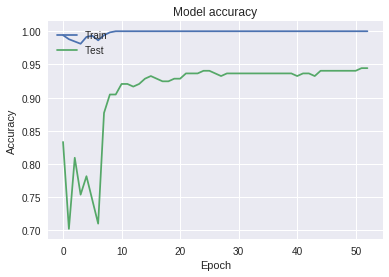

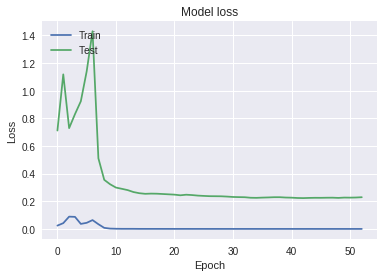

In [9]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()